# PINN: Physics-Informed Neural Network

## Solve the linearized Hasegawa-Wakatani eq.
$$ \frac{\partial n}{\partial t} + \kappa \frac{\partial \phi}{\partial y} - C (\phi - n) = 0 $$
$$ \frac{\partial \partial_y^2 \phi}{\partial t} - C (\phi - n) = 0 $$
$n(t,y)$: Density perturbation  
$\phi(t,y)$: Electrostatic potential perturbation  
$\kappa = 5.0$: Density gradient parameter  
$C = 3.0$: Adiabaticity parameter

In [1]:
# ----------------------------
# 必要なライブラリのインポート
# ----------------------------
import jax                         # JAX: 高速な数値計算・自動微分・JITコンパイルを提供するライブラリ
import jax.numpy as jnp            # JAX版NumPy: GPU/TPU対応の数値計算モジュール
from flax import nnx               # Flax NNX: JAX向けのニューラルネットワーク構築ライブラリ
import optax                       # Optax: JAX向けの最適化アルゴリズム（SGD, Adamなど）を提供するライブラリ
import matplotlib.pyplot as plt    # Matplotlib: グラフ描画ライブラリ（可視化に使用）
from scipy.stats.qmc import Sobol  # Sobol列: 準乱数系列（均一な点配置に使える）
from time import time as timer     # 時間計測関数（処理時間測定）

In [2]:
# --- 問題定義 ---
D = 2  # 入力座標の次元数（x,y)
K = 2  # 出力変数の次元数 ux(x,y), uy(x,y)

Ly = 20.0  # y方向ボックスサイズ
t_max = 4.0 # 上限時刻

kappa = 5.0
cc = 3.0

### 初期分布:固有関数
def analytic_wave_solution(k_init, phi_k_init, t2, y2):
    k = k_init
    omega_r = cc*(1+k**2)/(2*jnp.sqrt(2)*k**2)*jnp.sqrt(jnp.sqrt(1+16*kappa**2*k**6/(cc**2*(1+k**2)**4))-1)
    gamma = cc*(1+k**2)/(2*jnp.sqrt(2)*k**2)*(-jnp.sqrt(2)+jnp.sqrt(jnp.sqrt(1+16*kappa**2*k**6/(cc**2*(1+k**2)**4))+1))
    omega=omega_r+1j*gamma
    n_k_init = (1 - 1j*omega*k**2/cc)*phi_k_init
    phi = (phi_k_init * jnp.exp(1j*(k*y2-omega*t2))).real
    n = (n_k_init * jnp.exp(1j*(k*y2-omega*t2))).real
    return n, phi
k_init = 3 * 2*jnp.pi/Ly
phi_k_init = 1.0 + 0j




# ----------------------------
# ニューラルネットワークモデルの定義(MLP: 多層パーセプトロン)
# ----------------------------
class MLP(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(in_features=D,   out_features=100, rngs=rngs) # D次元入力ベクトル → 100
        self.linear2 = nnx.Linear(in_features=100, out_features=100, rngs=rngs) # 100 → 100
        self.linear3 = nnx.Linear(in_features=100, out_features=100, rngs=rngs) # 100 → 100
        self.linear4 = nnx.Linear(in_features=100, out_features=K,   rngs=rngs) # 100 → K次元出力ベクトル

    def __call__(self, x):            # x: (N, D) ... D 次元ベクトルを N セット入力
        x = nnx.tanh(self.linear1(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = nnx.tanh(self.linear2(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = nnx.tanh(self.linear3(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = self.linear4(x)           # 最終層は全結合線形変換のみ
        return x                      # x: (N, K) ... K 次元ベクトルを N セット出力

# ----------------------------
# ニューラルネットワークモデルの定義(y方向周期性を持つMLPモデル)
#    入力 (t, y) → (t, sin(2*pi*y/Ly), cos(2*pi*y/Ly)) の入力変換層を加えることで、
#    y座標に関してy=0とy=Lyでの周期性を課すようにモデルを制限
# ----------------------------
class MLP_yPeriodic(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(in_features=D+1, out_features=100, rngs=rngs) # D次元入力ベクトル → 100
        self.linear2 = nnx.Linear(in_features=100, out_features=100, rngs=rngs) # 100 → 100
        self.linear3 = nnx.Linear(in_features=100, out_features=100, rngs=rngs) # 100 → 100
        self.linear4 = nnx.Linear(in_features=100, out_features=K,   rngs=rngs) # 100 → K次元出力ベクトル

    def __call__(self, x):            # x: (N, D) ... D 次元ベクトルを N セット入力
        t, y = x[:,0], x[:,1]
        x = jnp.stack([t, jnp.sin(y*2*jnp.pi/Ly), jnp.cos(y*2*jnp.pi/Ly)], axis=-1)
        x = nnx.tanh(self.linear1(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = nnx.tanh(self.linear2(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = nnx.tanh(self.linear3(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = self.linear4(x)           # 最終層は全結合線形変換のみ
        return x                      # x: (N, K) ... K 次元ベクトルを N セット出力

# # ----------------------------
# # ニューラルネットワークモデルの定義(y方向周期性を持ち、かつ初期条件を満たすMLPモデル)
# # ----------------------------
# class MLP_yPeriodic_InitEmbed(nnx.Module):
#     def __init__(self, *, rngs: nnx.Rngs):
#         self.linear1 = nnx.Linear(in_features=D+1, out_features=50, rngs=rngs) # D次元入力ベクトル → 100
#         self.linear2 = nnx.Linear(in_features=50, out_features=50, rngs=rngs) # 100 → 100
#         self.linear3 = nnx.Linear(in_features=50, out_features=50, rngs=rngs) # 100 → 100
#         self.linear4 = nnx.Linear(in_features=50, out_features=K,   rngs=rngs) # 100 → K次元出力ベクトル

#     def init_profile(self, y):
#         t0 = jnp.zeros_like(y)
#         n0, phi0 = analytic_wave_solution(k_init, phi_k_init, t0, y)
#         return jnp.stack([n0, phi0], axis=-1)

#     def smooth_mask(self, t):
#         t = t.reshape(-1, 1)
#         return 1.0 - jnp.exp(-(t/0.5)**2)

#     def __call__(self, x):            # x: (N, D) ... D 次元ベクトルを N セット入力
#         t, y = x[:,0], x[:,1]
#         x = jnp.stack([t, jnp.sin(y*2*jnp.pi/Ly), jnp.cos(y*2*jnp.pi/Ly)], axis=-1)
#         x = nnx.tanh(self.linear1(x)) # 全結合線形変換の後、tanh活性化関数を施す
#         x = nnx.tanh(self.linear2(x)) # 全結合線形変換の後、tanh活性化関数を施す
#         x = nnx.tanh(self.linear3(x)) # 全結合線形変換の後、tanh活性化関数を施す
#         x = self.linear4(x)           # 最終層は全結合線形変換のみ
#         sm = self.smooth_mask(t)
#         u0 = self.init_profile(y)
#         x = sm * x + (1 - sm) * u0
#         return x                      # x: (N, K) ... K 次元ベクトルを N セット出力

def evaluate_each_loss(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.metrics.Average,
                       x_col, f_col, x_obs, u_obs):
    m = model
    # --- PDE項（H-W方程式の残差） ---
    def u_fn(x):
        return m(jnp.array(x).reshape(1,D))[0,:] # n(t,y)
    def n_fn(x):
        return m(jnp.array(x).reshape(1,D))[0,0] # n(t,y)
    def phi_fn(x):
        return m(jnp.array(x).reshape(1,D))[0,1] # phi(t,y)
    def dndt_fn(x):
        return jax.grad(n_fn)(x)[0]              # dn/dt
    def dphidy_fn(x):
        return jax.grad(phi_fn)(x)[1]            # dphi/dy
    def d2phidy2_fn(x):
        return jax.grad(dphidy_fn)(x)[1]         # d^2phi/dy^2
    def d3phidtdy2_fn(x):
        return jax.grad(d2phidy2_fn)(x)[0]       # d/dt(d^2phi/dy^2)
    n = jax.vmap(n_fn)(x_col)
    phi = jax.vmap(phi_fn)(x_col)
    dndt = jax.vmap(dndt_fn)(x_col)
    dphidy = jax.vmap(dphidy_fn)(x_col)
    d3phidtdy2 = jax.vmap(d3phidtdy2_fn)(x_col)
    res = (dndt + kappa * dphidy - cc * (phi-n))**2 + (d3phidtdy2 - cc * (phi-n))**2
    loss_pde = jnp.mean(res) # PDE損失（平均二乗誤差）

    # --- データ項（観測値とNN出力の誤差） ---
    u_pred = m(x_obs)[:, :]                # 観測点におけるNN出力（shape: (N_obs,)）
    loss_data = jnp.mean(jnp.sum((u_pred - u_obs)**2,axis=-1)) # データ損失（平均二乗誤差）

    # --- 周期項 ---
    t = jnp.linspace(0, t_max, 400)
    yl = jnp.zeros(400)
    yr = Ly*jnp.ones(400)
    x_l = jnp.stack([t,yl], axis=-1)
    x_r = jnp.stack([t,yr], axis=-1)
    u_l = m(x_l)[:,:]
    u_r = m(x_r)[:,:]
    dudx_fn = jax.jacobian(u_fn)
    dudx_l = jax.vmap(dudx_fn)(x_l)
    dudx_r = jax.vmap(dudx_fn)(x_r)
    res = jnp.sum((u_l-u_r)**2,axis=-1) + jnp.sum((dudx_l-dudx_r)**2,axis=(-2,-1))
    loss_period = jnp.mean(res)

    # --- 全体損失（同等重みで和を取る） ---
    return loss_pde, loss_data, loss_period




# ----------------------------
# PINN 長谷川-若谷方程式 ソルバークラス
# ----------------------------
class PINN():
    def __init__(self, nn_model: nnx.Module, lr: float = 1e-3):
        self.nn_model = nn_model # ニューラルネットワークモデル
        self.optimizer = nnx.Optimizer(self.nn_model, optax.adam(lr)) # 最適化器 (Adam)
        self.metrics = nnx.metrics.Average('loss') # 損失関数値を追跡するメトリクス

    # ニューラルネットワークの学習（モデル更新）
    def train(self, x_col, f_col, x_obs, u_obs, n_epochs=1500):
        for epoch in range(n_epochs + 1):
            loss = jit_train_step(self.nn_model, self.optimizer, self.metrics, x_col, f_col, x_obs, u_obs)
            if epoch % (n_epochs // 10) == 0:
                # print(f"[Epoch {epoch}] loss={self.metrics.compute()}")
                # print(f"[Epoch {epoch}] loss={loss}")
                loss_pde, loss_data, loss_period = evaluate_each_loss(self.nn_model, self.optimizer, self.metrics, x_col, f_col, x_obs, u_obs)
                print(f"[Epoch {epoch}] loss_pde, loss_data, loss_period =", loss_pde, loss_data, loss_period)

    # 学習済みモデルを使って予測
    def predict(self, x):
        return self.nn_model(x)[:,:]

# ----------------------------
# 学習ステップの定義
#    Just-in-time (JIT)コンパイルによる高速化のため、外部関数として定義
# ----------------------------
@nnx.jit
def jit_train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.metrics.Average,
                   x_col, f_col, x_obs, u_obs):

    def loss_fn(m: nnx.Module):
        # --- PDE項（H-W方程式の残差） ---
        def u_fn(x):
            return m(jnp.array(x).reshape(1,D))[0,:] # n(t,y)
        def n_fn(x):
            return m(jnp.array(x).reshape(1,D))[0,0] # n(t,y)
        def phi_fn(x):
            return m(jnp.array(x).reshape(1,D))[0,1] # phi(t,y)
        def dndt_fn(x):
            return jax.grad(n_fn)(x)[0]              # dn/dt
        def dphidy_fn(x):
            return jax.grad(phi_fn)(x)[1]            # dphi/dy
        def d2phidy2_fn(x):
            return jax.grad(dphidy_fn)(x)[1]         # d^2phi/dy^2
        def d3phidtdy2_fn(x):
            return jax.grad(d2phidy2_fn)(x)[0]       # d/dt(d^2phi/dy^2)
        n = jax.vmap(n_fn)(x_col)
        phi = jax.vmap(phi_fn)(x_col)
        dndt = jax.vmap(dndt_fn)(x_col)
        dphidy = jax.vmap(dphidy_fn)(x_col)
        d3phidtdy2 = jax.vmap(d3phidtdy2_fn)(x_col)
        res = (dndt + kappa * dphidy - cc * (phi-n))**2 + (d3phidtdy2 - cc * (phi-n))**2
        loss_pde = jnp.mean(res) # PDE損失（平均二乗誤差）

        # --- データ項（観測値とNN出力の誤差） ---
        u_pred = m(x_obs)[:, :]                # 観測点におけるNN出力（shape: (N_obs,)）
        loss_data = jnp.mean(jnp.sum((u_pred - u_obs)**2,axis=-1)) # データ損失（平均二乗誤差）

        # # --- 周期項 ---
        # t = jnp.linspace(0, t_max, 400)
        # yl = jnp.zeros(400)
        # yr = Ly*jnp.ones(400)
        # x_l = jnp.stack([t,yl], axis=-1)
        # x_r = jnp.stack([t,yr], axis=-1)
        # u_l = m(x_l)[:,:]
        # u_r = m(x_r)[:,:]
        # dudx_fn = jax.jacobian(u_fn)
        # dudx_l = jax.vmap(dudx_fn)(x_l)
        # dudx_r = jax.vmap(dudx_fn)(x_r)
        # res = jnp.sum((u_l-u_r)**2,axis=-1) + jnp.sum((dudx_l-dudx_r)**2,axis=(-2,-1))
        # loss_period = jnp.mean(res)
        loss_period = 0.0

        # --- 全体損失（同等重みで和を取る） ---
        return loss_pde + loss_data + loss_period

    loss, grads = nnx.value_and_grad(loss_fn)(model) # 損失とその勾配を計算
    optimizer.update(grads)   # オプティマイザに勾配を渡し、NNモデルパラメータを上書き更新
    metrics.update(loss=loss) # 損失を記録
    return loss

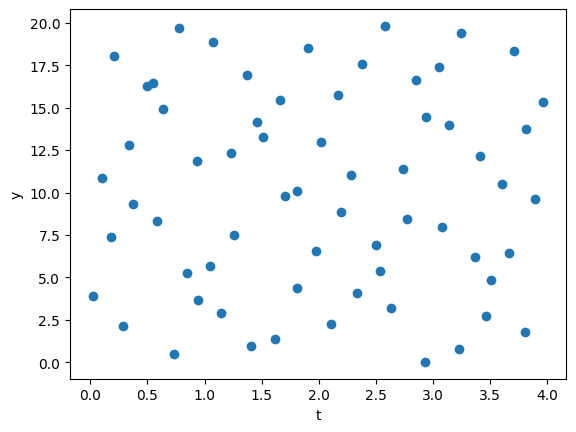

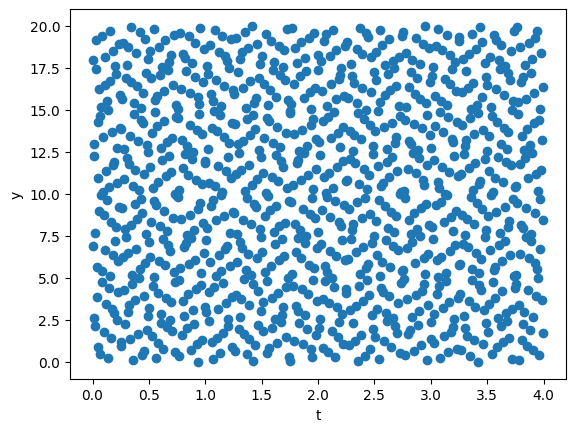

[Epoch 0] loss_pde, loss_data, loss_period = 2.9178963 43.405792 3.5765692e-14
[Epoch 100] loss_pde, loss_data, loss_period = 0.17982134 41.33367 6.791419e-14
[Epoch 200] loss_pde, loss_data, loss_period = 0.79108435 38.40297 2.803747e-13
[Epoch 300] loss_pde, loss_data, loss_period = 2.0696743 30.764433 2.2466076e-12
[Epoch 400] loss_pde, loss_data, loss_period = 3.2071958 18.248652 1.2425667e-11
[Epoch 500] loss_pde, loss_data, loss_period = 3.1881075 9.835954 3.202963e-11
[Epoch 600] loss_pde, loss_data, loss_period = 2.82675 5.337332 4.7916643e-11
[Epoch 700] loss_pde, loss_data, loss_period = 2.0102227 2.989543 5.673381e-11
[Epoch 800] loss_pde, loss_data, loss_period = 1.5181079 1.7326614 7.5345646e-11
[Epoch 900] loss_pde, loss_data, loss_period = 1.1728252 1.092346 8.207401e-11
[Epoch 1000] loss_pde, loss_data, loss_period = 0.90455025 0.7096554 8.597359e-11
Elapsed time [sec] = 94.90171813964844


In [3]:
# ----------------------------
# メイン実行ブロック
# ----------------------------

N_obs = 120 # 初期値分布のサンプリング点数

### 初期分布:乱数
# t0 = jnp.zeros(N_obs)
# key = jax.random.PRNGKey(0)
# u0 = 1e-4 * jax.random.normal(key, (N_obs, K))

### 初期分布:ガウシアン
# y = jnp.linspace(0, Ly, N_obs)
# t0 = jnp.zeros(N_obs)
# n0 = (y-Ly/2)*jnp.exp(-((y-Ly/2)/(0.05*Ly))**2)
# phi0 = jnp.zeros_like(n0)
# u0 = jnp.stack([n0,phi0], axis=-1)

### 初期分布:固有関数

# ### (i) 初期・終時刻での観測点
# t0 = jnp.zeros(N_obs)
# y0 = jnp.linspace(0, Ly, N_obs)
# # t_batch = t0
# # y_batch = y0
# t1 = jnp.ones(N_obs) * t_max
# y1 = y0
# t_batch = jnp.concatenate([t0, t1], axis=0)
# y_batch = jnp.concatenate([y0, y1],axis=0)
# x_obs = jnp.stack([t_batch,y_batch], axis=-1) # 観測点 x

### (ii) ランダムでまばらな観測点
sampler = Sobol(d=D, scramble=True, seed=40)  # Sobol点列（低偏差系列）でほぼ均質な乱数配置
x_obs = jnp.array(sampler.random_base2(m=6)) # 2^8 = 256個のCollocation
scale = jnp.array([[t_max, Ly] for i in range(x_obs.shape[0])])
x_obs = scale * x_obs
t_batch = x_obs[:,0]
y_batch = x_obs[:,1]

# ### (iii) 定点観測
# t0 = jnp.linspace(0, t_max, N_obs)
# y0 = jnp.ones(N_obs) * Ly/5
# y1 = jnp.ones(N_obs) * Ly/5*2
# y2 = jnp.ones(N_obs) * Ly/5*4
# y3 = jnp.ones(N_obs) * Ly/5*5
# t_batch = jnp.concatenate([t0, t0, t0, t0], axis=0)
# y_batch = jnp.concatenate([y0, y1, y2, y3],axis=0)
# x_obs = jnp.stack([t_batch,y_batch], axis=-1) # 観測点 x

# 観測点における固有関数値の計算
n_batch, phi_batch = analytic_wave_solution(k_init, phi_k_init, t_batch, y_batch)
u_obs = jnp.stack([n_batch,phi_batch], axis=-1) # 観測値 u(x)

# ## PINNのt=0の境界条件として与えた初期分布のプロット
# plt.plot(x_obs[:,1],u_obs[:,0],label="n")
# plt.plot(x_obs[:,1],u_obs[:,1],label="phi")
# plt.legend()
# plt.show()

### PINNの観測点のプロット
plt.scatter(x_obs[:,0],x_obs[:,1])
plt.xlabel("t")
plt.ylabel("y")
plt.show()


# --- PDE評価位置 (Collocation points) の選定 ---
sampler = Sobol(d=D, scramble=True, seed=0)  # Sobol点列（低偏差系列）でほぼ均質な乱数配置
x_col = jnp.array(sampler.random_base2(m=10)) # 2^8 = 256個のCollocation
scale = jnp.array([[t_max, Ly] for i in range(x_col.shape[0])])
x_col = scale * x_col

### [0,t_max][0,Ly]の2次元座標上で一様乱数によりCollocation pointsを生成。
plt.scatter(x_col[:,0],x_col[:,1])
plt.xlabel("t")
plt.ylabel("y")
plt.show()
f_col = jnp.zeros_like(x_col)

# --- PINN学習 ---
# nn_model = MLP(rngs=nnx.Rngs(0))     # ニューラルネットワークの初期化
nn_model = MLP_yPeriodic(rngs=nnx.Rngs(0))     # ニューラルネットワークの初期化
# nn_model = MLP_yPeriodic_InitEmbed(rngs=nnx.Rngs(0))     # ニューラルネットワークの初期化
pinn_solver = PINN(nn_model) # PINNソルバーインスタンスを作成
t0 = timer()
pinn_solver.train(x_col, f_col, x_obs, u_obs, n_epochs=1000) # 上記問題に対して学習実行
t1 = timer(); print("Elapsed time [sec] =", t1 - t0)

### 得られたPINNによる予測 $n(t,y)$ を可視化してみる

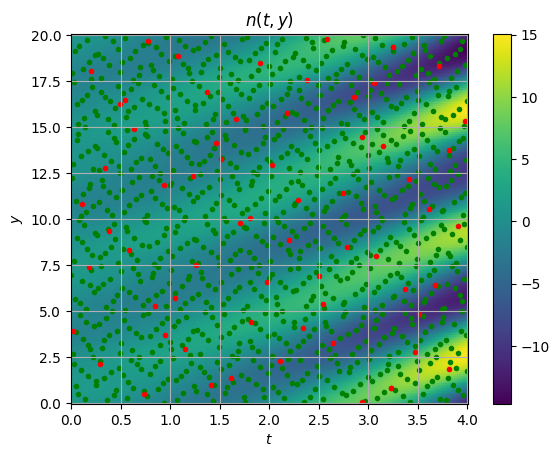

In [4]:
# --- 予測と可視化 ---
y_plot = jnp.linspace(0, Ly, 200)    # 可視化用の均等点（200点）
t_plot = jnp.linspace(0, t_max, 600) # 可視化用の均等点（600点）
y2, t2 = jnp.meshgrid(y_plot, t_plot)
x_plot = jnp.stack([t2.flatten(), y2.flatten()], axis=-1)
u_pred = pinn_solver.predict(x_plot)            # 学習済みモデルで予測
u_pred = u_pred.reshape(len(t_plot), len(y_plot), 2)

fig = plt.figure()
ax = fig.add_subplot(111)
quad = ax.pcolormesh(t2, y2, u_pred[:,:,0], label=r"Density $n$")
ax.scatter(x_col[:, 0], x_col[:, 1], marker=".", c="green", label="Colloc.")
ax.scatter(x_obs[:, 0], x_obs[:,1], marker=".", c="red", label="BC")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_title(r"$n(t,y)$")
fig.colorbar(quad)
# ax.legend()
ax.grid()
plt.show()

### PINNの予測と解析解の比較

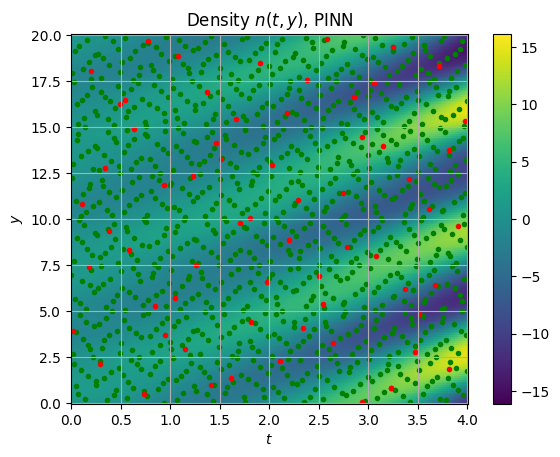

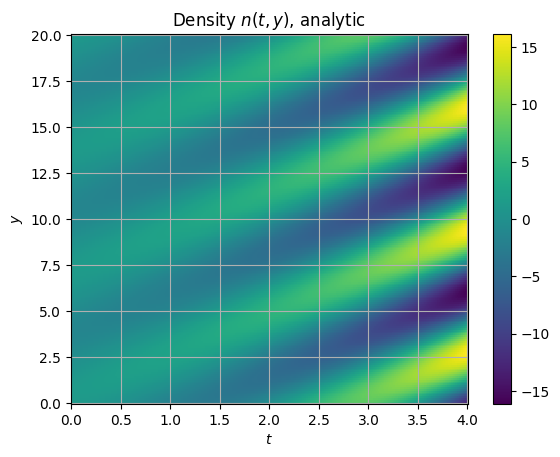

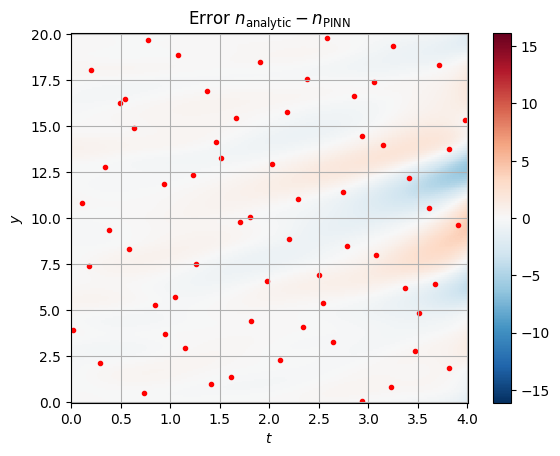

In [8]:
n_analytic, phi_analytic = analytic_wave_solution(k_init, phi_k_init, t2, y2)
vmax = max(n_analytic.max(), -n_analytic.min())

### PINNによる予測のプロット
fig = plt.figure()
ax = fig.add_subplot(111)
quad = ax.pcolormesh(t2, y2, u_pred[:,:,0], label=r"Density $n$",vmax=vmax,vmin=-vmax)
ax.scatter(x_col[:, 0], x_col[:, 1], marker=".", c="green", label="Colloc.")
ax.scatter(x_obs[:, 0], x_obs[:,1], marker=".", c="red", label="BC")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_title(r"Density $n(t,y)$, PINN")
fig.colorbar(quad)
ax.grid()
plt.show()

### 解析解のプロット
fig = plt.figure()
ax = fig.add_subplot(111)
quad = ax.pcolormesh(t2, y2, n_analytic, label=r"Density $n$",vmax=vmax,vmin=-vmax)
# ax.scatter(x_obs[:, 0], x_obs[:,1], marker=".", c="red", label="BC")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_title(r"Density $n(t,y)$, analytic")
fig.colorbar(quad)
ax.grid()
plt.show()

### 誤差＝解析解-PINN予測値のプロット
fig = plt.figure()
ax = fig.add_subplot(111)
quad = ax.pcolormesh(t2, y2, n_analytic - u_pred[:,:,0], label=r"Density $n$", vmax=vmax,vmin=-vmax, cmap="RdBu_r")
ax.scatter(x_obs[:, 0], x_obs[:,1], marker=".", c="red", label="BC")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_title(r"Error $n_\mathrm{analytic} - n_\mathrm{PINN}$")
fig.colorbar(quad)
ax.grid()
plt.show()

### PINNによる予測のアニメーション表示

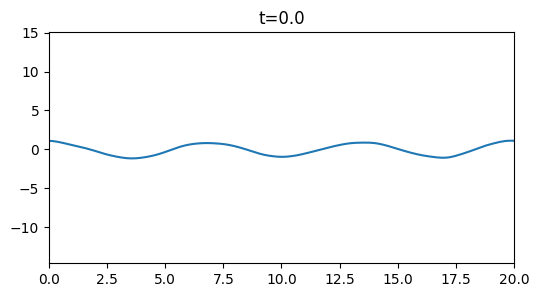

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig=plt.figure(figsize=(6,3))
ax=fig.add_subplot()

def update_ax(i):
  ax.clear()
  ax.plot(y_plot, u_pred[i,:,1])
  # ax.plot(y_plot+Ly, u_pred[i,:,1])
  ax.set_title("t={:}".format(t_plot[i]))
  ax.set_xlim(0,Ly)
  # ### 周期性チェック
  # ax.plot(y_plot+Ly, u_pred[i,:,1])
  # ax.set_xlim(0,2*Ly)
  ax.set_ylim(u_pred.min(),u_pred.max())
  return

ani = FuncAnimation(fig, update_ax,
                    frames=range(0,len(t_plot),10), interval=100)
#ani.save('advection.mp4', writer="ffmpeg", dpi=100)

#plt.show()
HTML(ani.to_jshtml())

### 観測点と得られたPINN予測の対比プロット  
初期分布を基に時間発展を精度よく解くような問題設定では従来の数値シミュレーションの方が得意。  
一方、時空間上まばらな観測データがあり、それを疎な境界条件として偏微分方程式を満たす解を求めるという問題設定では、PINNのような数値変分法による反復解法が活用できる。


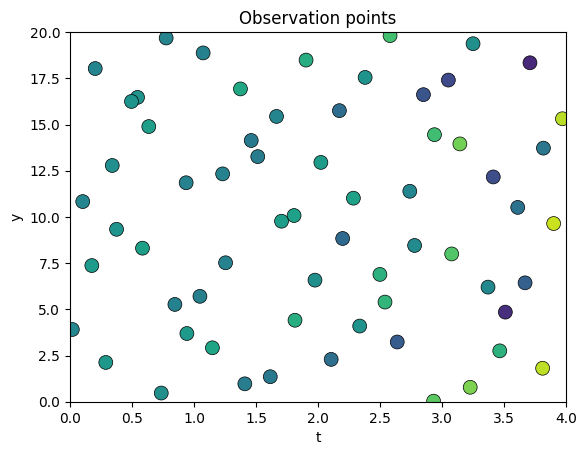

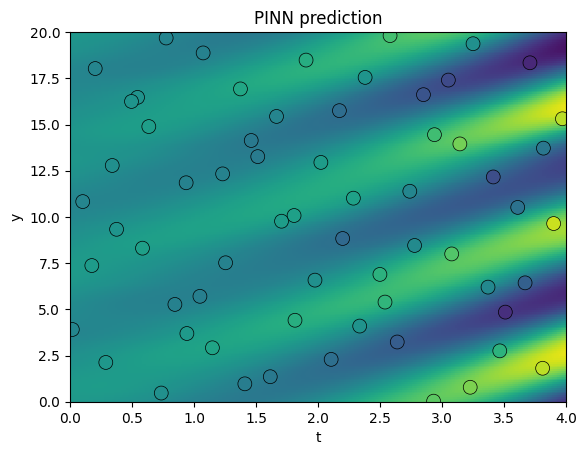

In [10]:
vmax = max(n_analytic.max(), -n_analytic.min())
### PINNの観測点のプロット。その位置での値で色付け。
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_obs[:,0],x_obs[:,1],c=u_obs[:,0],marker="o",s=100,edgecolors="k",linewidths=0.5,vmax=vmax,vmin=-vmax)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_xlim(0,t_max)
ax.set_ylim(0,Ly)
ax.set_title("Observation points")
plt.show()

### PINNの予測と観測点を一緒にプロット
fig = plt.figure()
ax = fig.add_subplot(111)
quad = ax.pcolormesh(t2, y2, u_pred[:,:,0], label=r"Density $n$",vmax=vmax,vmin=-vmax)
ax.scatter(x_obs[:,0],x_obs[:,1],c=u_obs[:,0],marker="o",s=100,edgecolors="k",linewidths=0.5,vmax=vmax,vmin=-vmax)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_xlim(0,t_max)
ax.set_ylim(0,Ly)
ax.set_title("PINN prediction")
plt.show()


In [11]:
### 長谷川-若谷方程式の線形分散関係の理論式
# kmin = 2*jnp.pi/Ly
# k = kmin*jnp.arange(20)
# omega_r = cc*(1+k**2)/(2*jnp.sqrt(2)*k**2)*jnp.sqrt(jnp.sqrt(1+16*kappa**2*k**6/(cc**2*(1+k**2)**4))-1)
# gamma = cc*(1+k**2)/(2*jnp.sqrt(2)*k**2)*(-jnp.sqrt(2)+jnp.sqrt(jnp.sqrt(1+16*kappa**2*k**6/(cc**2*(1+k**2)**4))+1))
# omega=omega_r+1j*gamma

# phi_k = jnp.ones_like(k)
# n_k = (1 - 1j*omega*k**2/cc)*phi_k

# disp = -1j*k**2/cc*omega**2 + (1+k**2)*omega-k*kappa
# # disp = -1j*omega*n_k + 1j*k*kappa*phi_k - cc*(phi_k - n_k)
# # disp = 1j*omega*k**2*phi_k - cc*(phi_k - n_k)
# plt.plot(k,omega_r,"o-")
# plt.plot(k,gamma,"x-")
# plt.plot(k,disp.real)
# plt.plot(k,disp.imag)
# plt.show()